In [1]:
# !pip install sklearn

In [2]:
import sys
sys.path.append('/irad_users/smithk/beholder-interns')

In [3]:
# imports
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd
import metrics

In [4]:
# define a function to get arrays from dataframe for sklearn training
def get_data(df, cols):
    return df[cols].to_numpy(),df['distance'].to_numpy()

In [21]:
# try an sklearn model right out of the box w/out the visual data
train_data = pd.read_csv('/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotations.csv')
# remove all boxes where distance was not recorded 
train_data.drop(train_data.index[train_data['distance'] == -1], inplace=True)

# remove all boxes to force the training and test sets to have identical ranges 
#train_data.drop(train_data.index[train_data['distance'] > 100], inplace=True)

#shuffle dataset
train_data = train_data.sample(frac=1).reset_index(drop=True)
# encode classes 
classes = [0 if c == 'car' else 1 for c in train_data['class'] ]
train_data.drop('class', axis=1)
train_data['class'] = classes
# scaling: works horribly 
# scale = RobustScaler()
# train_data['distance'] = scale.fit_transform(train_data['distance'].to_numpy().reshape(-1, 1))
# train_data.drop(train_data.index[train_data['distance'] == 0.0], inplace=True)
# dist_min = train_data['distance'].min()
# dist_max = train_data['distance'].max()
# normalizing: works horribly 
#train_data['distance'] = train_data['distance'].apply(lambda x: 2*(x-dist_min)/(dist_max-dist_min) -1)
feature_cols = [
    'x-min',
    'y-min',
    'x-max',
    'y-max',
    'class'
]

# collapse dataframe info to array
X, y = get_data(train_data, feature_cols)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)


Text(0.5, 1.0, 'Train Set Distances')

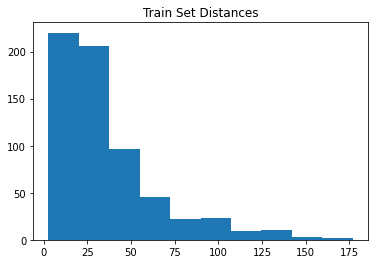

In [22]:
plt.hist(train_y)
plt.title('Train Set Distances')

Text(0.5, 1.0, 'Test Set Distances')

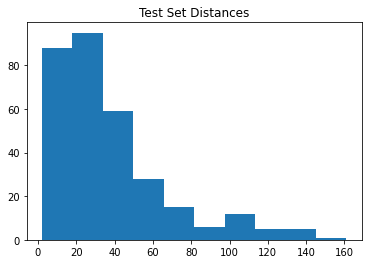

In [23]:
plt.hist(test_y)
plt.title('Test Set Distances')

In [24]:
# try a random forest regressor
regr = RandomForestRegressor(n_estimators=100)
regr.fit(train_x, train_y)

# get predictions for test data
train_preds = regr.predict(train_x)
test_preds = regr.predict(test_x)

In [9]:
# un normalize data
# train_preds = (train_preds+1)*(dist_max-dist_min)/2.0 + dist_min
# train_y = (train_y+1)*(dist_max-dist_min)/2.0 + dist_min
# test_preds = (test_preds+1)*(dist_max-dist_min)/2.0 + dist_min
# train_x = (train_x+1)*(dist_max-dist_min)/2.0 + dist_min
        
# un-scale data
# train_preds = scale.inverse_transform(train_preds.reshape(-1, 1))
# train_y = scale.inverse_transform(train_y.reshape(-1, 1))
# test_preds = scale.inverse_transform(test_preds.reshape(-1, 1))
# train_x = scale.inverse_transform(test_y.reshape(-1, 1))

In [25]:
# calculate train metrics
abs_rel_dist = np.mean(metrics.abs_relative_distance(train_preds, train_y))
sq_rel_dist = metrics.sq_relative_distance(train_preds, train_y)
rmse = metrics.rmse(train_preds, train_y)
log_rmse = metrics.log_rmse(train_preds, train_y)

# print metrics
print('Train Set Metrics')
print('----------------')
print('Abs Rel:{:.3f}'.format(abs_rel_dist))
print('Sq Rel: {:.3f}'.format(sq_rel_dist))
print('RMSE: {:.3f}'.format(rmse))
print('RMSE log: {:.3f}'.format(log_rmse))

# calculate test metrics
abs_rel_dist = np.mean(metrics.abs_relative_distance(test_preds, test_y))
sq_rel_dist = metrics.sq_relative_distance(test_preds, test_y)
rmse = metrics.rmse(test_preds, test_y)
log_rmse = metrics.log_rmse(test_preds, test_y)

# print metrics
print()
print('Test Set Metrics')
print('----------------')
print('Abs Rel:{:.3f}'.format(abs_rel_dist))
print('Sq Rel: {:.3f}'.format(sq_rel_dist))
print('RMSE: {:.3f}'.format(rmse))
print('RMSE log: {:.3f}'.format(log_rmse))

Train Set Metrics
----------------
Abs Rel:0.096
Sq Rel: 0.590
RMSE: 4.916
RMSE log: 0.141

Test Set Metrics
----------------
Abs Rel:0.228
Sq Rel: 2.856
RMSE: 12.261
RMSE log: 0.281


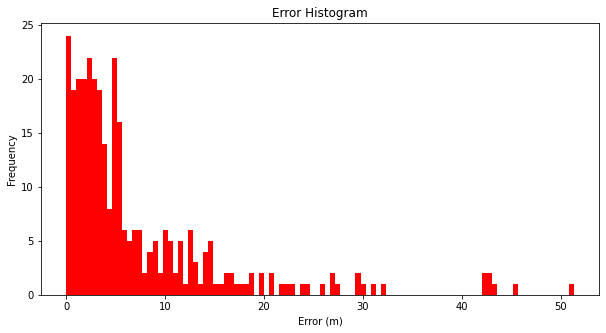

In [11]:
# plot an error histogram
abs_rel_errors = metrics.abs_relative_distance(test_preds, test_y)
abs_rel_errors *= test_y
fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.hist(abs_rel_errors, bins=100, color='r')
ax.set_title('Error Histogram')
ax.set_ylabel('Frequency')
ax.set_xlabel('Error (m)')
plt.show()